In [68]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
df = pd.read_csv("bank-full.csv", delimiter=";")

In [70]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### 1. Data Preparation

In [71]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [72]:
df = df[['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y']]

In [73]:
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [74]:
# Creating categorical and numerical variables
categorical = df.select_dtypes(include="object").drop('y', axis = 1).columns.to_list()
categorical

['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

In [75]:
numerical = df.select_dtypes(include='number').columns.to_list()
numerical

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [76]:
df['y'] = df['y'].map({'yes': 1, 'no': 0})

### 2. Splitting the data

In [77]:
from sklearn.model_selection import train_test_split

In [78]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [79]:
len(df_train), len(df_val), len(df_test)

(27126, 9042, 9043)

In [80]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [81]:
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

### 3. ROC AUC feature importance

In [82]:
features = ["balance", "day", "duration", "previous"]

In [83]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [84]:
def compute_auc_feature_importance(df, y):
    auc_results = []
    for feature in features:
        # Computing the ROC AUC score using the feature as a score (or prediction)
        auc = roc_auc_score(y, df_train[feature])
        if auc <0.5:
            auc = roc_auc_score(y, -df_train[feature])
        else:
            auc = roc_auc_score(y, df_train[feature])
        auc_results.append([feature, auc])
    # Converting to DataFrame
    auc_df = pd.DataFrame(auc_results, columns = ["Feature", "AUC score"])
    auc_df_sorted = auc_df.sort_values(by = "AUC score", ascending = False)
    return auc_df_sorted

In [85]:
compute_auc_feature_importance(df_train, y_train)

,Feature,AUC score
2,duration,0.814700
3,previous,0.598565
0,balance,0.588831
1,day,0.525958


### 4. Training the model

In [86]:
from sklearn.feature_extraction import DictVectorizer

In [87]:
# Appling one-hot-encoding using DictVectorizer and train the logistic regression with these parameters
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [88]:
from sklearn.linear_model import LogisticRegression

In [89]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [90]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [91]:
y_pred = model.predict_proba(X_val)[:, 1]

In [92]:
y_decision = (y_pred >= 0.5)

In [93]:
acc = round((y_val == y_decision).mean(), 3)

In [94]:
acc

0.898

### 5. Precision and Recall

In [97]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [98]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

# Calculating Precision and Recall
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

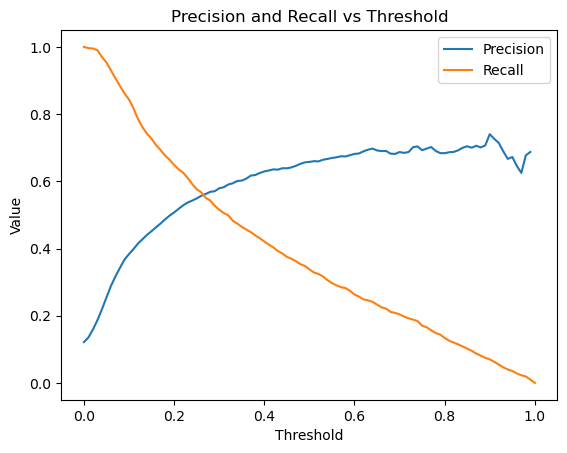

In [99]:
# Plotting Precision and Recall curves
plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.legend()
plt.title('Precision and Recall vs Threshold')
plt.show()


In [100]:
# Find where Precision and Recall curves intersect
df_scores['diff'] = np.abs(df_scores['precision'] - df_scores['recall'])
min_diff_threshold = df_scores.loc[df_scores['diff'].idxmin(), 'threshold']
print(f'Precision and Recall curves intersect at threshold: {min_diff_threshold:.3f}')

Precision and Recall curves intersect at threshold: 0.260


### 6. F1 score

In [118]:
F1_scores = []

In [119]:
df_scores['F1'] = 2 * df_scores.precision * df_scores.recall/(df_scores.precision + df_scores.recall)

In [120]:
max_f1_index =df_scores['F1'].idxmax()

In [121]:
threshold_at_max_f1 = df_scores['threshold'].loc[max_f1_index]

In [122]:
print(threshold_at_max_f1)

0.22


### 7. 5-Fold CV

In [123]:
from sklearn.model_selection import KFold

In [124]:
def train(df_train, y_train):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [125]:
dv, model = train(df_train, y_train)

In [126]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [127]:
y_pred = predict(df_val, dv, model)

In [128]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print(np.std(scores))

0.0057757090378566965


### 8. Hyperparameter Tuning

In [129]:
!pip install tqdm

In [130]:
from tqdm.auto import tqdm

In [131]:
def train(df_train, y_train, C):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [139]:
n_splits = 5
results = []  # To store C, mean AUC, and std deviation for each C

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        # Assuming train and predict functions are already defined
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    mean_auc = np.mean(scores)
    std_auc = np.std(scores)
    
    # Storing results as a tuple (C, mean AUC, std deviation)
    results.append((C, mean_auc, std_auc))

    # Printing result for each C
    print('C=%s, Mean AUC=%.3f, Std Deviation=%.3f' % (C, mean_auc, std_auc))

# Converting results into a numpy array for easier manipulation
results_array = np.array(results)

# Finding the index of the minimum standard deviation
min_std_idx = np.argmin(results_array[:, 2])
best_C_std = results_array[min_std_idx, 0]
best_mean_auc_std = results_array[min_std_idx, 1]
best_std_auc = results_array[min_std_idx, 2]

# Finding the index of the maximum mean AUC
max_mean_auc_idx = np.argmax(results_array[:, 1])
best_C_mean_auc = results_array[max_mean_auc_idx, 0]
best_mean_auc = results_array[max_mean_auc_idx, 1]
best_std_mean_auc = results_array[max_mean_auc_idx, 2]

print('\nBest C with lowest standard deviation:')
print('C=%.6f, Mean AUC=%.3f, Std Deviation=%.3f' % (best_C_std, best_mean_auc_std, best_std_auc))

print('\nBest C with highest mean AUC:')
print('C=%.6f, Mean AUC=%.3f, Std Deviation=%.3f' % (best_C_mean_auc, best_mean_auc, best_std_mean_auc))


 33%|███▎      | 1/3 [00:04<00:08,  4.30s/it]

C=1e-06, Mean AUC=0.701, Std Deviation=0.009


 67%|██████▋   | 2/3 [00:09<00:04,  4.82s/it]

C=0.001, Mean AUC=0.861, Std Deviation=0.007


100%|██████████| 3/3 [00:15<00:00,  5.17s/it]

C=1, Mean AUC=0.906, Std Deviation=0.006

Best C with lowest standard deviation:
C=1.000000, Mean AUC=0.906, Std Deviation=0.006

Best C with highest mean AUC:
C=1.000000, Mean AUC=0.906, Std Deviation=0.006
